# Content-Based Filtering Recommendation System

This notebook demonstrates how to build a content-based recommendation system using song data. The approach involves:

1. **Loading and Preprocessing Data**
2. **Feature Extraction**
3. **Building the Recommendation System**
4. **Evaluating the System**
5. **Saving and Loading the Model**
6. **Integration with Spotify API**

## 1. Loading and Preprocessing Data

First, we load the combined JSON file and preprocess the data.


In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
import joblib  
import json

# Load the combined JSON file with utf-8 encoding
with open('../datasets/songs_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Display the first few rows of the dataframe
df.head()



,artist,timestamp,similars,tags,track_id,title
0,Casual,2011-08-02 20:13:25.674526,"[[TRABACN128F425B784, 0.871737], [TRIAINV12903...","[[Bay Area, 100], [hieroglyiphics, 100], [clas...",TRAAAAW128F429D538,I Didn't Mean To
1,The Box Tops,2011-08-12 04:04:21.577908,"[[TRBRSNN128F4284E8C, 1], [TRHYADV128F4285EC1,...","[[60s, 100], [soul, 52], [pop, 41], [rock, 35]...",TRAAABD128F429CF47,Soul Deep
2,La Sonora Santanera,2011-08-09 18:24:38.890272,"[[TRPHLNJ128F9348769, 1], [TRVWNCB128F9343925,...","[[latin, 100]]",TRAAADZ128F9348C2E,Amor De Cabaret
3,Adam Ant,2011-08-11 21:57:49.876264,"[[TRWXGJB12903CCFE02, 1], [TRKDLTP128F427F677,...","[[new wave, 100], [80s, 66], [freedom, 33], [s...",TRAAAEF128F4273421,Something Girls
4,Gob,2011-08-09 01:59:41.352247,"[[TRTOVWD128F92F4227, 1], [TRUXNUD128F92F41D0,...","[[punk rock, 100], [punk, 60]]",TRAAAFD128F92F423A,Face the Ashes


EDA

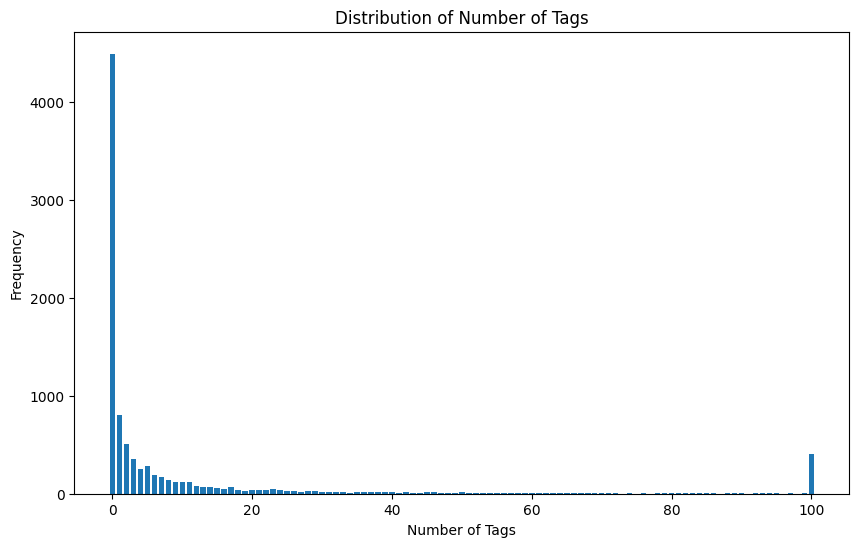

In [6]:
import matplotlib.pyplot as plt

# Basic statistics
df.describe()

# Check for missing values
df.isnull().sum()

# Plot distribution of tags
tag_counts = df['tags'].apply(lambda x: len(x)).value_counts()
plt.figure(figsize=(10, 6))
plt.bar(tag_counts.index, tag_counts.values)
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Tags')
plt.show()


## 2. Feature Extraction

We use TF-IDF vectorization to transform the text data into a numerical format that can be used for similarity computation.


In [7]:
# Create a combined feature for content-based recommendation
df['tags_combined'] = df['tags'].apply(lambda x: ' '.join([tag[0] for tag in x]))
df['title_artist'] = df['title'] + ' ' + df['artist']

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['tags_combined'])

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

## 3. Building the Recommendation System

We compute the cosine similarity matrix to measure the similarity between songs and define a function to get recommendations.


In [9]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a DataFrame for the similarity matrix
similarity_df = pd.DataFrame(cosine_sim, index=df['track_id'], columns=df['track_id'])

# Save the similarity matrix
similarity_df.to_csv('similarity_matrix.csv')


In [10]:
def get_recommendations(track_id, top_n=10):
    sim_scores = similarity_df[track_id].sort_values(ascending=False)
    top_tracks = sim_scores.head(top_n).index
    return df[df['track_id'].isin(top_tracks)]

# Example usage
recommended_songs = get_recommendations('TRAAAAW128F429D538', top_n=5)
recommended_songs[['title', 'artist', 'track_id']]


,title,artist,track_id
0,I Didn't Mean To,Casual,TRAAAAW128F429D538
303,OAKtown,Casual,TRABACN128F425B784
3316,No Escapin' This,The Beatnuts,TRAMDCB128F42772E3
6581,Intro,Erick Sermon,TRAYFKN128F148C55A
8388,Head Banger,EPMD,TRBFBOG128F9356C6E


In [11]:
# Save the recommendation function
joblib.dump(get_recommendations, 'recommendation_model.pkl')

# Load the recommendation function
get_recommendations = joblib.load('recommendation_model.pkl')


4. Integrating with Spotify API
Objective: Use Spotify API to get recommendations and provide links to tracks.

In [12]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.exceptions import SpotifyException

# Initialize Spotify client
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id='380a6b3535dc420a905dccf328a0e165',
                                               client_secret='b0ca7947448246d28aafc40f49610cf4',
                                               redirect_uri='http://localhost:8888/callback',
                                               scope='user-library-read'))
def search_spotify_track(title, artist):
    try:
        results = sp.search(q=f'track:{title} artist:{artist}', type='track', limit=1)
        tracks = results['tracks']['items']
        if tracks:
            return tracks[0]['id']  # Spotify track ID
        return None
    except SpotifyException as e:
        print(f"Error during search: {e}")
        return None

def get_spotify_recommendations(seed_tracks=None, limit=10):
    if not seed_tracks:
        print("No seed tracks provided.")
        return []

    valid_seed_tracks = [track_id for track_id in seed_tracks if track_id]
    if not valid_seed_tracks:
        print("No valid seed tracks available.")
        return []

    print(f"Valid seed tracks: {valid_seed_tracks}")

    try:
        recommendations = sp.recommendations(seed_tracks=valid_seed_tracks, limit=limit)
        print(f"Recommendations: {recommendations}")
        return recommendations['tracks']
    except SpotifyException as e:
        print(f"Error during recommendations: http status: {e.http_status}, code: {e.code} - {e}")
        return []

    
# Example usage
lastfm_tracks = [
    {"title": "I Didn't Mean To", "artist": "Casual"}
]

spotify_track_ids = []
for track in lastfm_tracks:
    spotify_id = search_spotify_track(track['title'], track['artist'])
    if spotify_id:
        spotify_track_ids.append(spotify_id)

print(f"Found Spotify track IDs: {spotify_track_ids}")

if spotify_track_ids:
    spotify_recs = get_spotify_recommendations(seed_tracks=spotify_track_ids)
    for track in spotify_recs:
        print(f"{track['name']} by {track['artists'][0]['name']}")
else:
    print("No valid Spotify track IDs found.")


Found Spotify track IDs: ['31sqbc5iOZIKgzhZWppDuj']
Valid seed tracks: ['31sqbc5iOZIKgzhZWppDuj']
Recommendations: {'tracks': [{'album': {'album_type': 'ALBUM', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0cnbaGjcH77bWAV1MgVSJh'}, 'href': 'https://api.spotify.com/v1/artists/0cnbaGjcH77bWAV1MgVSJh', 'id': '0cnbaGjcH77bWAV1MgVSJh', 'name': 'Nine', 'type': 'artist', 'uri': 'spotify:artist:0cnbaGjcH77bWAV1MgVSJh'}], 'available_markets': ['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'DE', 'EC', 'EE', 'SV', 'FI', 'FR', 'GR', 'GT', 'HN', 'HK', 'HU', 'IS', 'IE', 'IT', 'LV', 'LT', 'LU', 'MY', 'MT', 'MX', 'NL', 'NZ', 'NI', 'NO', 'PA', 'PY', 'PE', 'PH', 'PL', 'PT', 'SG', 'SK', 'ES', 'SE', 'CH', 'TW', 'TR', 'UY', 'US', 'GB', 'AD', 'LI', 'MC', 'ID', 'JP', 'TH', 'VN', 'RO', 'IL', 'ZA', 'SA', 'AE', 'BH', 'QA', 'OM', 'KW', 'EG', 'MA', 'DZ', 'TN', 'LB', 'JO', 'PS', 'IN', 'BY', 'KZ', 'MD', 'UA', 'AL', 'BA', 'HR', 'ME', 'MK', 'RS

In [16]:

def display_recommendations(tracks):
    recs_data = []
    for track in tracks:
        recs_data.append({
            'Title': track['name'],
            'Artist': track['artists'][0]['name'],
            'Spotify Link': f"https://open.spotify.com/track/{track['id']}"  
        })
    
    recommendations_df = pd.DataFrame(recs_data)
    return recommendations_df


# Example track data
example_track = {"title": "Shape of You", "artist": "Ed Sheeran"}

# Search for the track on Spotify
spotify_id = search_spotify_track(example_track['title'], example_track['artist'])
print(f"Found Spotify track ID: {spotify_id}")

# Generate a Spotify link
if spotify_id:
    spotify_link = f"https://open.spotify.com/track/{spotify_id}"
    print(f"Spotify Link: {spotify_link}")

# # Example track data
example_track_id = '7qiZfU4dY1lWllzX7mPBI3'  

# Get recommendations
spotify_recs = get_spotify_recommendations(seed_tracks=[example_track_id])
print(f"Spotify Recommendations: {spotify_recs}")

# Display recommendations
recommendations_df = display_recommendations(spotify_recs)
print(recommendations_df)


Found Spotify track ID: 7qiZfU4dY1lWllzX7mPBI3
Spotify Link: https://open.spotify.com/track/7qiZfU4dY1lWllzX7mPBI3
Valid seed tracks: ['7qiZfU4dY1lWllzX7mPBI3']
Recommendations: {'tracks': [{'album': {'album_type': 'ALBUM', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0MlOPi3zIDMVrfA9R04Fe3'}, 'href': 'https://api.spotify.com/v1/artists/0MlOPi3zIDMVrfA9R04Fe3', 'id': '0MlOPi3zIDMVrfA9R04Fe3', 'name': 'American Authors', 'type': 'artist', 'uri': 'spotify:artist:0MlOPi3zIDMVrfA9R04Fe3'}], 'available_markets': ['AR', 'BE', 'BO', 'BR', 'BG', 'CA', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'EC', 'EE', 'SV', 'FI', 'FR', 'GR', 'GT', 'HN', 'HK', 'HU', 'IS', 'IE', 'LV', 'LT', 'LU', 'MY', 'MT', 'MX', 'NL', 'NI', 'NO', 'PA', 'PY', 'PE', 'PH', 'PL', 'PT', 'SG', 'SK', 'ES', 'SE', 'CH', 'TW', 'TR', 'UY', 'US', 'GB', 'AD', 'LI', 'MC', 'ID', 'JP', 'TH', 'VN', 'RO', 'IL', 'ZA', 'SA', 'AE', 'BH', 'QA', 'OM', 'KW', 'EG', 'MA', 'DZ', 'TN', 'LB', 'JO', 'PS', 'IN', 'BY', 'KZ', 

In [17]:
# Configure pandas to display full column width
pd.set_option('display.max_colwidth', None)

# Display the DataFrame
import IPython.display as display
display.display(recommendations_df)


,Title,Artist,Spotify Link
0,Best Day Of My Life,American Authors,https://open.spotify.com/track/5Hroj5K7vLpIG4FNCRIjbP
1,Your Song,Rita Ora,https://open.spotify.com/track/46xkXPGjR9Ig9BcaTUNus3
2,Heaven,Julia Michaels,https://open.spotify.com/track/3cysp2UU6xmV61ZlnQsa8s
3,Story of My Life,One Direction,https://open.spotify.com/track/4nVBt6MZDDP6tRVdQTgxJg
4,Money On My Mind,Sam Smith,https://open.spotify.com/track/15HsdLcI9txtlLpsHBbEjn
5,Just the Way You Are,Bruno Mars,https://open.spotify.com/track/7BqBn9nzAq8spo5e7cZ0dJ
6,Someone You Loved,Lewis Capaldi,https://open.spotify.com/track/7qEHsqek33rTcFNT9PFqLf
7,Rain,The Script,https://open.spotify.com/track/2QWP8NYYplOqEFBYGCcq0S
8,Made You Look,Meghan Trainor,https://open.spotify.com/track/0QHEIqNKsMoOY5urbzN48u
9,Rescue Me,OneRepublic,https://open.spotify.com/track/37LNNQNbL1YLyutBG6aWRx
